**Linear Regression Modelling**

**Load Data and Import Libraries**

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator



df = spark.read.load("/FileStore/tables/airbnb_transf_dataframe_full")
X_train = spark.read.load("/FileStore/tables/airbnb_transf_dataframe_train")
X_test = spark.read.load("/FileStore/tables/airbnb_transf_dataframe_test")



**Creating and Fitting Baseline Model**

In [0]:


# Regression Evaluator
regression_evaluator_r2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="r2")
regression_evaluator_rmse = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="log_price",metricName="rmse")

# Defining the model
lr_baseline = LinearRegression(featuresCol = 'simple_features', labelCol='log_price', maxIter=10)

# Creating Pipeline Estimator
pipeline_lr_baseline = Pipeline(stages = [lr_baseline])


paramGrid = ParamGridBuilder()\
    .addGrid(lr_baseline.maxIter, [10, 15]) \
    .addGrid(lr_baseline.elasticNetParam, [0.0, 0.5, 1.0])\
    .addGrid(lr_baseline.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator = pipeline_lr_baseline,
                         estimatorParamMaps=paramGrid,
                         evaluator = regression_evaluator_r2,
                         numFolds = 5)

cvModel_lr_baseline = crossval.fit(df)



/databricks/spark/python/pyspark/ml/util.py:762: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

**Creating and Fitting Model with Text Features**

In [0]:
# Defining the model
lr_text_features = LinearRegression(featuresCol = 'features', labelCol='log_price', maxIter=10)

# Creating Pipeline Estimator
pipeline_lr_text_features = Pipeline(stages = [lr_text_features])
paramGrid = ParamGridBuilder()\
    .addGrid(lr_text_features.maxIter, [10, 15]) \
    .addGrid(lr_text_features.elasticNetParam, [0.0, 0.5, 1.0])\
    .addGrid(lr_text_features.regParam, [0.1, 0.01]) \
    .build()

#paramGrid = ParamGridBuilder().build()

crossval = CrossValidator(estimator = pipeline_lr_text_features,
                         estimatorParamMaps=paramGrid,
                         evaluator = regression_evaluator_r2,
                         numFolds = 5)

cvModel_lr_text_features = crossval.fit(df)

**Evaluating the models**

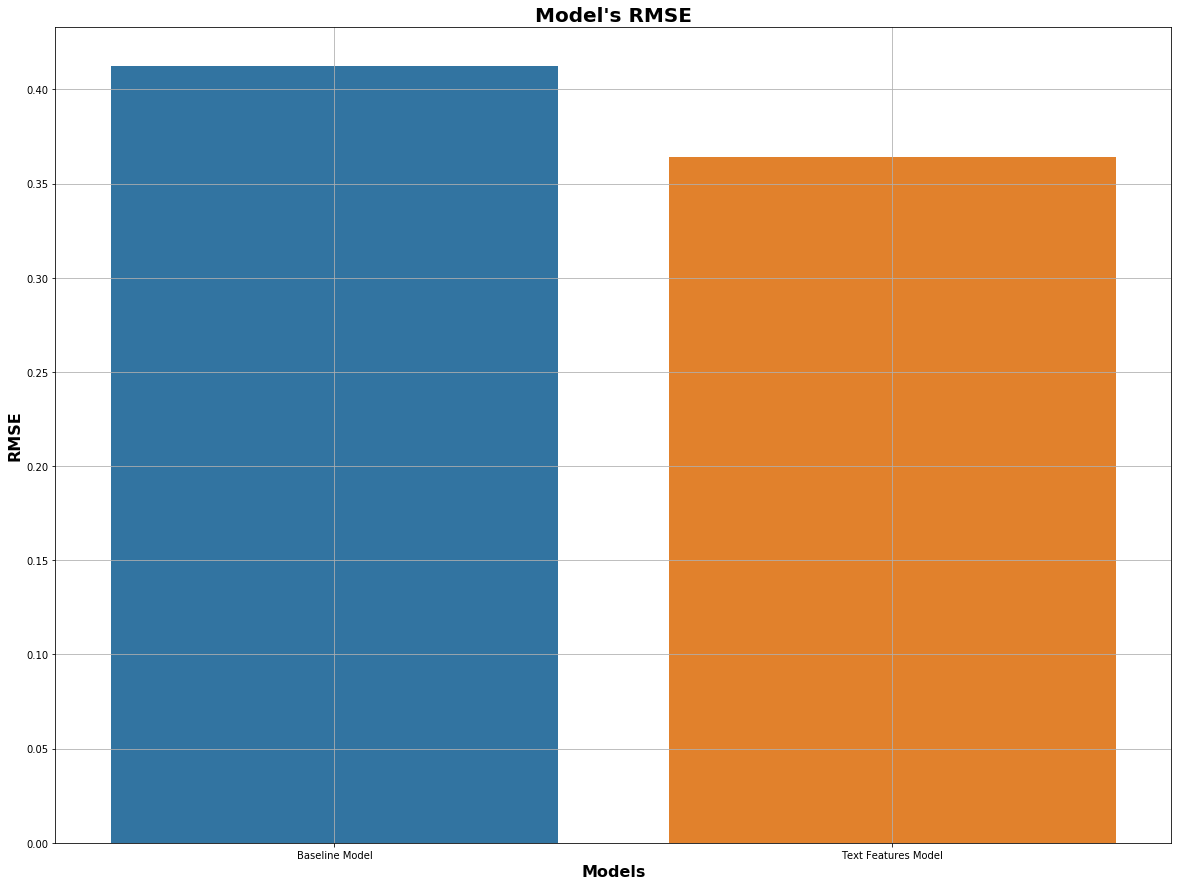

In [0]:
baseline_summary = cvModel_lr_baseline.bestModel.stages[-1].summary
baseline_rmse = baseline_summary.rootMeanSquaredError

text_features_summary = cvModel_lr_text_features.bestModel.stages[-1].summary
text_features_rmse = text_features_summary.rootMeanSquaredError


rmse = [baseline_rmse, text_features_rmse]
models = ['Baseline Model', 'Text Features Model']

fig, ax = plt.subplots(figsize = (20,15))
res = sns.barplot(models, rmse)
# Plot using seaborn
sns.set(font_scale = 4)
plt.title("Model's RMSE", fontsize = 20, fontweight = 'bold')
plt.xlabel('Models', fontsize = 16, fontweight = 'bold')
plt.ylabel('RMSE', fontsize = 16, fontweight = 'bold')
ax.grid(True)


plt.show()

**Comparing Models and Parameters**

In [0]:
data = {"baseline (r2 score)": cvModel_lr_baseline.avgMetrics, "text_features (r2 score)":cvModel_lr_text_features.avgMetrics}
results_df = pd.DataFrame(data=data)
results_df.index = [f"model_{i}" for i in range(12)]
display(results_df)

baseline (r2 score),text_features (r2 score)
0.5687713397632143,0.632037150026109
0.5887832219111386,0.6382648540218063
0.4810720640130065,0.4859040486469326
0.5771977360662761,0.6360266586379559
0.45087614199313303,0.44134292962114363
0.5636492942748055,0.6120159239308167
0.5687713397640775,0.632037150026832
0.5887832219105513,0.6382648540193236
0.48199661636947766,0.48719896729639334
0.5802835491093213,0.6382567920987384


**Model 1**: {

  maxIter = 10
  
  elasticNet = 0
  
  regParam = 0.1

}

**Model 2**: {

  maxIter = 10
  
  elasticNet = 0
  
  regParam = 0.01

}

**Model 3**: {

  maxIter = 10
  
  elasticNet = 0.5
  
  regParam = 0.1

}

**Model 4**: {

  maxIter = 10
  
  elasticNet = 0.5
  
  regParam = 0.01

}

**Model 5**: {

  maxIter = 10
  
  elasticNet = 1
  
  regParam = 0.1

}

**Model 6**: {

  maxIter = 10
  
  elasticNet = 1
  
  regParam = 0.01

}

**Model 7**: {

  maxIter = 15
  
  elasticNet = 0
  
  regParam = 0.1

}

**Model 8**: {

  maxIter = 15

  elasticNet = 0
  
  regParam = 0.01

}

**Model 9**: {

  maxIter = 15
  
  elasticNet = 0.5
  
  regParam = 0.1

}

**Model 10**: {

  maxIter = 15

  elasticNet = 0.5

  regParam = 0.01

}

**Model 11**: {

  maxIter = 15
  
  elasticNet = 1
  
  regParam = 0.1

}

**Model 12**: {

  maxIter = 15
  
  elasticNet = 1
  
  regParam = 0.01

}

**Visualizing Predictions**

In [0]:
predictions_baseline = cvModel_lr_baseline.transform(X_test)

# Create a view or table

temp_table_name = "predictions_baseline_csv"

predictions_baseline.createOrReplaceTempView(temp_table_name)

predictions_text_features = cvModel_lr_text_features.transform(X_test)

# Create a view or table

temp_table_name = "predictions_text_features_csv"

predictions_text_features.createOrReplaceTempView(temp_table_name)

In [0]:
%sql

-- Survival rate

SELECT log_price AS target, prediction
from predictions_baseline_csv
ORDER BY log_price



target,prediction
2.3978952727983707,4.815124771993055
2.3978952727983707,4.03332685710555
2.3978952727983707,4.397116743231777
2.3978952727983707,4.11244742489248
2.3978952727983707,4.167390274148573
2.639057329615259,3.5668104524455373
2.772588722239781,3.8648914702959587
2.772588722239781,5.532703381351325
2.833213344056216,5.1540830762876055
3.044522437723423,3.838970139957212


In [0]:
%sql


SELECT log_price AS target, prediction
from predictions_text_features_csv
ORDER BY log_price


target,prediction
2.3978952727983707,4.8738934000286065
2.3978952727983707,3.9489890189255163
2.3978952727983707,4.02603909912861
2.3978952727983707,4.04803901631044
2.3978952727983707,4.043945995600183
2.639057329615259,3.5696199723421955
2.772588722239781,3.5726653784291216
2.772588722239781,5.368716637812383
2.833213344056216,5.4049817796682476
3.044522437723423,3.726138996014754
